This notebook shows the position uncertainties of pulsars from various techniques.

In [1]:
import sys

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from statsmodels.iolib.table import SimpleTable

from astropy.table import Table, join, vstack, unique, Column
from astropy.time import Time
from psrcrf_tools import count_psr_nb
import seaborn as sns

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Define some functions.

In [2]:
def divide_table(psr_table, msp_list):
    """Divide table into MSP and non-MSP
    """

    # MSP table
    temp_table1 = Table([])

    # Non-MSP table
    temp_table2 = Table(psr_table)

    for msp_name in msp_list:

        mask = ((psr_table["psr_name"] == msp_name))
        temp_table1 = vstack((temp_table1, psr_table[mask]))

        mask = ((temp_table2["psr_name"] != msp_name))
        temp_table2 = temp_table2[mask]

    msp_table = Table(temp_table1, masked=False)
    nmp_table = Table(temp_table2, masked=False)

    return msp_table, nmp_table

# 1 Gaia pulsar

In [3]:
# gaia_tab = Table.read("../data/edr3_psrcatv1.65.fits")
# gaia_tab = Table.read("../data/edr3_psrcatv1.66.fits")
gaia_tab = Table.read("../data/edr3_psrcatv1.67.fits")

Find the list of MSPs in the *Gaia* list.

In [4]:
edr3_antf_table = Table.read("../data/edr3_psrcatv1.67.fits")
edr3_antf_table.sort("name")

B_over_G = 3.2e19 * np.sqrt(edr3_antf_table["p0"] * edr3_antf_table["p1"])

mask = (B_over_G <= 1e10)
gaia_msp_list = edr3_antf_table["name"][mask]

gaia_msp_list = gaia_msp_list.tolist()

Remove useless columns.

In [5]:
gaia_tab = gaia_tab['name', 'source_id', 'ra', 'ra_error', 'dec',
                    'dec_error', 'parallax', 'parallax_error',
                    'pmra', 'pmra_error', 'pmdec',
                    'pmdec_error', ]

gaia_tab.rename_columns([
    "name", "ra_error", "dec_error", "parallax", "parallax_error",
    "pmra_error", "pmdec_error"
], [
    "psr_name", "ra_err", "dec_err", "plx", "plx_err", "pmra_err", "pmdec_err"
])

Add a column for the position epoch.

In [6]:
pos_epoch = 2016.0 * np.ones(len(gaia_tab))
pos_epoch = Column(pos_epoch, name="jyr")
gaia_tab.add_column(pos_epoch)

Divide the *Gaia* table into two subtables.

In [7]:
gaia_msp_tab, gaia_nmp_tab = divide_table(gaia_tab, gaia_msp_list)

Check if all pulsars have *Gaia* proper motion.

In [8]:
# Sources without PM estimates
mask = (gaia_tab["pmra"] > 1e10)
nb_gaia_2sol = len(gaia_tab[mask])

print("{} PSRs in the Gaia EDR3 have a 2p solution:".format(nb_gaia_2sol))
print(gaia_tab[mask]["psr_name"])

1 PSRs in the Gaia EDR3 have a 2p solution:
 psr_name 
----------
J1546-5302


Plot the position formal uncertainties in the *Gaia* EDR3.

<Figure size 432x288 with 0 Axes>

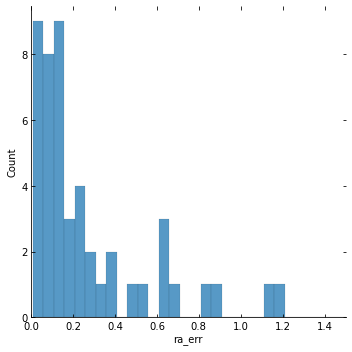

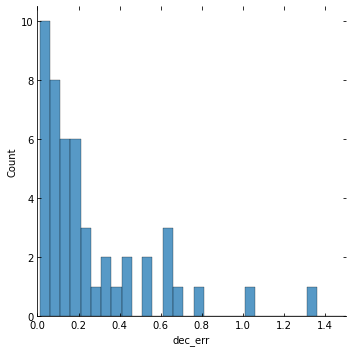

In [9]:
# sns.set_theme(style="darkgrid")
df = gaia_tab.to_pandas()

plt.clf()
sns.displot(
    df["ra_err"],
    binwidth=0.05, height=5, facet_kws=dict(margin_titles=True),
)
plt.xlim([0, 1.5])
plt.tight_layout()

sns.displot(
    df["dec_err"],
    binwidth=0.05, height=5, facet_kws=dict(margin_titles=True),
)
plt.xlim([0, 1.5])
plt.tight_layout()

# 2 VLBI pulsars

In [10]:
vlbi_tab = Table.read("../data/psrpi.dat", format="ascii")

vlbi_tab.sort("psr_name")

Transform the position epoch from the MJD format to Julian year.

In [11]:
jyr = Time(vlbi_tab["pos_epoch"], format="mjd")
jyr = Column(jyr.jyear, name="jyr")

vlbi_tab.add_column(jyr)

Add the list of VLBI MSPs.

In [12]:
vlbi_msp_list = ["J1022+1001", "J2010-1323",
                 "J2145-0750", "J2317+1439", "J1012+5307", "J1537+1155"]

Divide the VLBI pulsar table into two sub-tables.

In [13]:
vlbi_msp_tab, vlbi_nmp_tab = divide_table(vlbi_tab, vlbi_msp_list)

Plot the VLBI position formal uncertainties.

<Figure size 432x288 with 0 Axes>

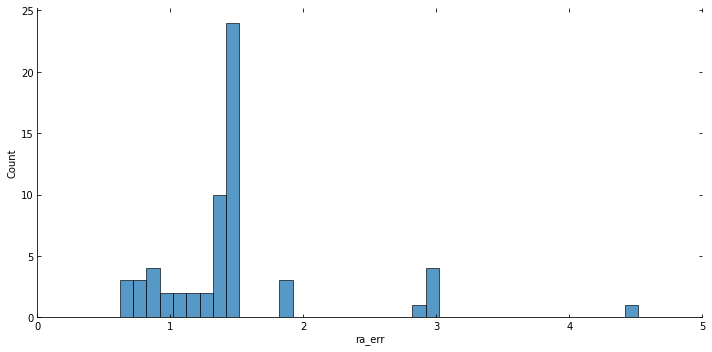

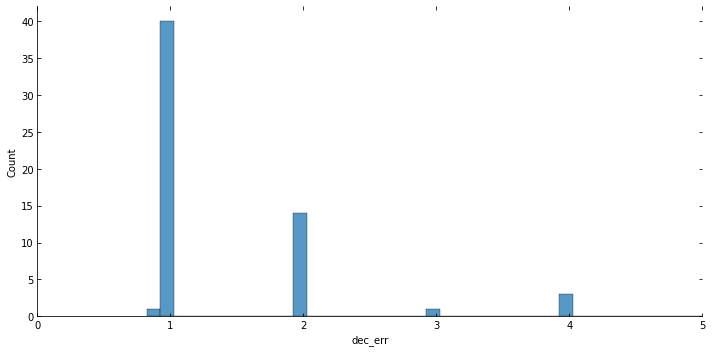

In [14]:
df = vlbi_tab.to_pandas()

plt.clf()
sns.displot(
    df["ra_err"],
    binwidth=0.1, aspect=2, height=5, facet_kws=dict(margin_titles=True),
)
plt.xlim([0, 5])
plt.tight_layout()

sns.displot(
    df["dec_err"],
    binwidth=0.1, aspect=2, height=5, facet_kws=dict(margin_titles=True),
)
plt.xlim([0, 5])
plt.tight_layout()

# 3 Timing pulsars

In [15]:
timing_gaia = Table.read("../data/timing_edr3.fits",)
timing_gaia.sort("psr_name")

nb_psr = len(timing_gaia.group_by("psr_name").groups)
nb_obs = len(timing_gaia)

print("There are {} Gaia pulsars having {} positional measurements.".format(
    nb_psr, nb_obs))

There are 33 Gaia pulsars having 70 positional measurements.


In [16]:
timing_vlbi = Table.read("../data/timing_vlbi.fits",)
timing_vlbi.sort("psr_name")

nb_psr = len(timing_vlbi.group_by("psr_name").groups)
nb_obs = len(timing_vlbi)

print("There are {} vlbi pulsars having {} positional measurements.".format(
    nb_psr, nb_obs))

There are 62 vlbi pulsars having 221 positional measurements.


Find the common pulsars between the Gaia and VLBI pulsar samples.

And I got one.

In [17]:
gaia_psr = [namei for namei in timing_gaia["psr_name"]]
vlbi_psr = [namei for namei in timing_vlbi["psr_name"]]

gaia_psr = Table((np.unique(gaia_psr),), names=["psr_name"])
vlbi_psr = Table((np.unique(vlbi_psr),), names=["psr_name"])

join(gaia_psr, vlbi_psr)

psr_name
str10
J0614+2229
J1012+5307


In [18]:
timing_tab = vstack((timing_gaia, timing_vlbi))
timing_tab.sort("pos_epoch")

timing_tab = unique(timing_tab)

In [19]:
count_psr_nb(timing_tab)

There are 93 pulsars with 281 measurements.


Convert the positional epoch from MJD to jyear.

In [20]:
jyr = Time(timing_tab["pos_epoch"], format="mjd")
jyr = Column(jyr.jyear, name="jyr")

timing_tab.add_column(jyr)

MSP list for all data.

In [21]:
msp_list = np.unique(vlbi_msp_list + gaia_msp_list)

Various versions of DE ephmeris.

In [22]:
eph_list = [ephi for ephi in timing_tab["eph"]]
np.unique(eph_list)

array(['DE200', 'DE405', 'DE421', 'DE430', 'DE436', 'DE4??'], dtype='<U5')

Divided the table according to the DE ephemerides.

In [23]:
tab200 = timing_tab[timing_tab["eph"] == "DE200"]
tab405 = timing_tab[timing_tab["eph"] == "DE405"]
tab421 = timing_tab[timing_tab["eph"] == "DE421"]
tab430 = timing_tab[timing_tab["eph"] == "DE430"]
tab436 = timing_tab[timing_tab["eph"] == "DE436"]
tabels = timing_tab[timing_tab["eph"] == "DE4??"]

Then divide all DE ephemerides tables into sub-tables.

In [24]:
msp_tab200, nmp_tab200 = divide_table(tab200, msp_list)

msp_tab405, nmp_tab405 = divide_table(tab405, msp_list)

msp_tab421, nmp_tab421 = divide_table(tab421, msp_list)

msp_tab430, nmp_tab430 = divide_table(tab430, msp_list)

msp_tab436, nmp_tab436 = divide_table(tab436, msp_list)

msp_tabels, nmp_tabels = divide_table(tabels, msp_list)

Plot the formal uncertainty for timing positions collected from literature.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


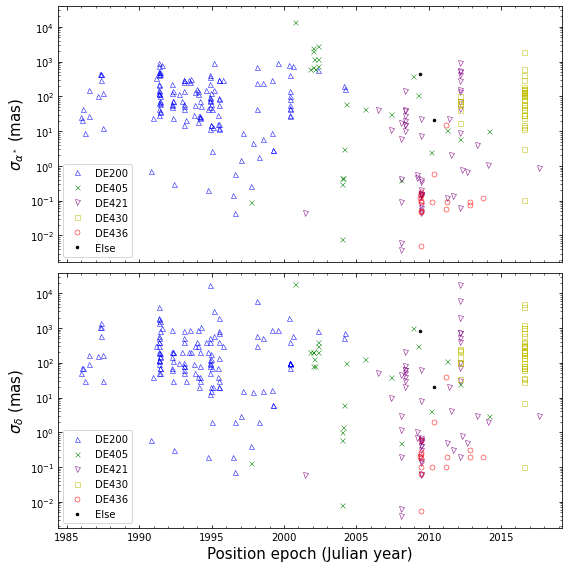

In [25]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8),
                               nrows=2,
                               sharex=True,
                               sharey=True)

ax0.plot(tab200["jyr"],
         tab200["ra_err"],
         "^",
         ms=5,
         label="DE200",
         mfc="none",
         mec="blue",
         mew=0.5)
ax0.plot(tab405["jyr"],
         tab405["ra_err"],
         "x",
         ms=5,
         label="DE405",
         mfc="none",
         mec="g",
         mew=0.5)
ax0.plot(tab421["jyr"],
         tab421["ra_err"],
         "v",
         ms=5,
         label="DE421",
         mfc="none",
         mec="purple",
         mew=0.5)
ax0.plot(tab430["jyr"],
         tab430["ra_err"],
         "s",
         ms=5,
         label="DE430",
         mfc="none",
         mec="y",
         mew=0.5)
ax0.plot(tab436["jyr"],
         tab436["ra_err"],
         "o",
         ms=5,
         label="DE436",
         mfc="none",
         mec="r",
         mew=0.5)
ax0.plot(tabels["jyr"], tabels["ra_err"], "k.", ms=5, label="Else")

ax1.plot(tab200["jyr"],
         tab200["dec_err"],
         "^",
         ms=5,
         label="DE200",
         mfc="none",
         mec="blue",
         mew=0.5)
ax1.plot(tab405["jyr"],
         tab405["dec_err"],
         "x",
         ms=5,
         label="DE405",
         mfc="none",
         mec="g",
         mew=0.5)
ax1.plot(tab421["jyr"],
         tab421["dec_err"],
         "v",
         ms=5,
         label="DE421",
         mfc="none",
         mec="purple",
         mew=0.5)
ax1.plot(tab430["jyr"],
         tab430["dec_err"],
         "s",
         ms=5,
         label="DE430",
         mfc="none",
         mec="y",
         mew=0.5)
ax1.plot(tab436["jyr"],
         tab436["dec_err"],
         "o",
         ms=5,
         label="DE436",
         mfc="none",
         mec="r",
         mew=0.5)
ax1.plot(tabels["jyr"], tabels["dec_err"], "k.", ms=5, label="Else")

ax0.set_yscale("log")
ax1.set_yscale("log")

ax1.xaxis.set_minor_locator(MultipleLocator(1))

# ax1.set_xlim([1984, 2020])
ax1.set_xlabel("Position epoch (Julian year)", fontsize=15)

ax0.set_ylabel("$\sigma_{\\alpha^*}$ (mas)", fontsize=15)
ax1.set_ylabel("$\sigma_{\delta}$ (mas)", fontsize=15)

ax0.legend()
ax1.legend()

plt.tight_layout()
plt.savefig("../plots/timing-err.eps")

In [26]:
def find_med_err(tab):

    nb_obs = len(tab)

    if nb_obs:

        nb_psr = len(tab.group_by("psr_name").groups)

        pos_epoch = np.median(tab["jyr"])

        ra_err = np.median(tab["ra_err"])
        dec_err = np.median(tab["dec_err"])

        pos_errs = np.sqrt(tab["ra_err"]**2 + tab["dec_err"]**2)
        pos_err = np.median(pos_errs)

        mask = (tab["pmra_err"] != 0)
        pmra_err = np.median(tab[mask]["pmra_err"])

        mask = (tab["pmdec_err"] != 0)
        pmdec_err = np.median(tab[mask]["pmdec_err"])

        mask = (tab["plx_err"] != 0)
        plx_err = np.median(tab[mask]["plx_err"])
    else:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0

    return nb_psr, nb_obs, pos_epoch, ra_err, dec_err, pos_err, plx_err, pmra_err, pmdec_err

In [27]:
sol_err = np.zeros((22, 9))

tabs = [
    gaia_tab, gaia_msp_tab, gaia_nmp_tab, vlbi_tab, vlbi_msp_tab, vlbi_nmp_tab,
    tab200, msp_tab200, nmp_tab200, tab405, msp_tab405, nmp_tab405, tab421,
    msp_tab421, nmp_tab421, tab430, msp_tab430, nmp_tab430, tab436, msp_tab436,
    nmp_tab436, tabels
]

for i in range(len(sol_err)):
    sol_err[i, :] = find_med_err(tabs[i])

myheaders = [
    "Nb.PSR", "Nb.Obs", "PosEpoch", "RA_err", "dec_err", "pos_err", "plx_err", "pmRA_err",
    "pmDec_err"
]
mystubs = [
    "Gaia", "Gaia (MSP)", "Gaia (NMP)", "VLBI", "VLBI (MSP)", "VLBI (NMP)",
    "DE200", "DE200 (MSP)", "DE200 (NMP)", "DE405", "DE405 (MSP)",
    "DE405 (NMP)", "DE421", "DE421 (MSP)", "DE421 (NMP)", "DE430",
    "DE430 (MSP)", "DE430 (NMP)", "DE436", "DE436 (MSP)", "DE436 (NMP)", "else"
]

tbl = SimpleTable(
    sol_err,
    myheaders,
    mystubs,
    title="Positional formal uncertainty for timing and VLBI positions (mas)",
    data_fmts=[
        "%2d",
        "%3d",
        "%7.2f",
        "%6.3f",
        "%6.3f",
        "%6.3f",
        "%6.3f",
        "%6.3f",
        "%6.3f",
    ])

print(tbl)

          Positional formal uncertainty for timing and VLBI positions (mas)           
            Nb.PSR Nb.Obs PosEpoch  RA_err dec_err pos_err  plx_err pmRA_err pmDec_err
--------------------------------------------------------------------------------------
Gaia            49     49  2016.00   0.157   0.178    0.219   0.234    0.218     0.234
Gaia (MSP)      23     23  2016.00   0.176   0.187    0.267   0.254    0.241     0.238
Gaia (NMP)      26     26  2016.00   0.143   0.139    0.199   0.152    0.201     0.174
VLBI            62     62  2012.20   1.440   1.000    1.764   0.060    0.090     0.120
VLBI (MSP)       6      6  2012.20   1.455   1.500    2.124   0.085    0.070     0.115
VLBI (NMP)      56     56  2012.20   1.431   1.000    1.761   0.055    0.090     0.120
DE200           75    142  1994.06  74.891 120.000  172.765   5.000    8.000    13.000
DE200 (MSP)     10     20  1996.83   2.764   4.500    5.008   5.000    0.700     1.400
DE200 (NMP)     65    122  1993.53  99.402 

/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/Neo/Scisoft/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/cx/w871dcfn6h18zc_07dj7mxgm0000gn/T/ipykernel_25250/1123719569.py:11: UserWarning: Warning: converting a masked element to nan.
  sol_err[i, :] = find_med_err(tabs[i])


Generate a citation list to be included in the table.

In [28]:
tab_content1 = """
ref	title	bibcode
smd93	Timing parameters for 59 pulsars.	1993MNRAS.262..449S
bhl+94	Discovery of Three Binary Millisecond Pulsars	1994ApJ...425L..41B
ant94	Timing Behavior of 96 Radio Pulsars	1994ApJ...422..671A
jml+95	Timing measurements for 45 pulsars.	1995A&A...293..795J
dgm+96	The New Northern Cross Pulsar System: Four Years of Pulsar Timing Observations	1996ApJS..106..611D
dsb+98	The Parkes Southern Pulsar Survey - III. Timing of long-period pulsars	1998MNRAS.297...28D
idb98	New timing parameters and positions for 16 southern radio pulsars.	1998MNRAS.295..397I
tsb+99	Millisecond pulsar velocities	1999MNRAS.307..925T
wmz+01	Pulsar timing at Urumqi Astronomical Observatory: observing system and results	2001MNRAS.328..855W
mlc+01	The Parkes multi-beam pulsar survey - I. Observing and data analysis systems, discovery and timing of 100 pulsars	2001MNRAS.328...17M
kmb+03	The Parkes Multibeam Pulsar Survey - III. Young pulsars and the discovery and timing of 200 pulsars	2003MNRAS.342.1299K
hlk+04	Long-term timing observations of 374 pulsars.	2004MNRAS.353.1311H
hfs+04	The Parkes multibeam pulsar survey - IV. Discovery of 180 pulsars and parameters for 281 previously known pulsars	2004MNRAS.352.1439H
zhw+05	Timing measurements and proper motions of 74 pulsars using the Nanshan radio telescope.	2005MNRAS.362.1189Z
lfl+06	The Parkes Multibeam Pulsar Survey - VI. Discovery and timing of 142 pulsars and a Galactic population analysis.	2006MNRAS.372..777L
hbo06	High-precision baseband timing of 15 millisecond pulsars	2006MNRAS.369.1502H
mfl+06	Discovery of 14 Radio Pulsars in a Survey of the Magellanic Clouds	2006ApJ...649..235M
vbc+09	Timing stability of millisecond pulsars and prospects for gravitational-wave detection	2009MNRAS.400..951V
rkp+11	Precise γ-ray Timing and Radio Observations of 17 Fermi γ-ray Pulsars	2011ApJS..194...17R
dfg+13	Limits on the Stochastic Gravitational Wave Background from the North American Nanohertz Observatory for Gravitational Waves	2013ApJ...762...94D
slr+14	The Green Bank Northern Celestial Cap Pulsar Survey. I. Survey Description, Data Analysis, and Initial Results	2014ApJ...791...67S
lwy+16	Proper motions of 15 pulsars: a comparison between Bayesian and frequentist algorithms.	2016MNRAS.460.4011L
dcl+16	High-precision timing of 42 millisecond pulsars with the European Pulsar Timing Array	2016MNRAS.458.3341D
mnf+16	The NANOGrav Nine-year Data Set: Astrometric Measurements of 37 Millisecond Pulsars	2016ApJ...818...92M
vlh+16	The International Pulsar Timing Array: First data release	2016MNRAS.458.1267V
rhc+16	Timing analysis for 20 millisecond pulsars in the Parkes Pulsar Timing Array	2016MNRAS.455.1751R
abb+18	The NANOGrav 11-year Data Set: High-precision Timing of 45 Millisecond Pulsars	2018ApJS..235...37A
jbs+19	The UTMOST pulsar timing programme I: Overview and first results	2019MNRAS.484.3691J
psj+19	Timing of young radio pulsars - I. Timing noise, periodic modulation, and proper motion	2019MNRAS.489.3810P
pdd+19	The International Pulsar Timing Array: second data release	2019MNRAS.490.4666P
lbs+20	The UTMOST pulsar timing programme - II. Timing noise across the pulsar population	2020MNRAS.494..228L
dym+20	Results of 12 yr of Pulsar Timing at Nanshan. I.	2020ApJ...896..140D
lys+20	New timing measurement results of 16 pulsars	2020PASJ...72...70L
rsc+21	The Parkes pulsar timing array second data release: timing analysis	2021MNRAS.507.2137R
psf+21	Study of 72 pulsars discovered in the PALFA survey: Timing analysis, glitch activity, emission variability, and a pulsar in an eccentric binary	2021arXiv210802320P
"""

tab_content2 = """
ref 	Title 	bibcode 	Comment
aft94	Orbital Variability in the Eclipsing Pulsar Binary PSR B1957+20 	1994ApJ...426L..85A 	1 PSR
cst96	Princeton-Arecibo Declination-Strip Survey for Millisecond Pulsars. I. 	1996ApJ...469..819C 	2 PSRs
kmb+96	Evidence from a precessing pulsar orbit for a neutron-star birth kick 	1996Natur.381..584K 	1 PSRs
bbm+97	Timing Measurements and Their Implications for Four Binary Millisecond Pulsars 	1997MNRAS.286..463B 	4 PSRs
sac+98	Measurement of Relativistic Orbital Decay in the PSR B1534+12 Binary System 	1998ApJ...505..352S 	1 PSR
kxc+99	Profile Instabilities of the Millisecond Pulsar PSR J1022+1001 	1999ApJ...520..324K 	ecliptic coordinate (Not used)
wdk+00	Timing Observations of Four Millisecond Pulsars with the Arecibo and Effelsberg Radio Telescopes 	2000ApJ...528..907W 	4 PSRs
clm+01	Discovery of Five Binary Radio Pulsars 	2001ApJ...548L.187C 	5 PSRs
lcw+01	Precision timing measurements of PSR J1012+5307 	2001MNRAS.326..274L 	1 PSR
eb01	Recycled Pulsars Discovered at High Radio Frequency 	2001ApJ...553..801E 	8 PSRs
stt+02	Studies of the Relativistic Binary Pulsar PSR B1534+12. I. Timing Analysis 	2002ApJ...581..501S 	1 PSR
kwh03	Geodetic Precession and Timing of the Relativistic Binary Pulsars PSR B1534+12 and PSR B1913+16 	2003ApJ...589..495K 	1 PSR
lkd+04	The parallax, mass and age of the PSR J2145-0750 binary system 	2004A&A...426..631L 	PM in ecliptic coordinate (transformed)
jml+09	Discovery of three new pulsars in a 610-MHz pulsar survey with the GMRT. 	2009MNRAS.398..943J 	No common PSR
jsb+09	Discovery and timing of the first 8gr8 Cygnus survey pulsars 	2009A&A...498..223J 	3 PSRs
lwj+09	Generic tests of the existence of the gravitational dipole radiation and the variation of the gravitational constant 	2009MNRAS.400..805L 	1 PSRs
gsf+11	High-precision Timing of Five Millisecond Pulsars: Space Velocities, Binary Evolution, and Equivalence Principles 	2011ApJ...743..102G 	5 PSRs
pgf+12	Binary Millisecond Pulsar Discovery via Gamma-Ray Pulsations 	2012Sci...338.1314P 	1 PSR
afw+13	A Massive Pulsar in a Compact Relativistic Binary 	2013Sci...340..448A 	1 PSR
cls+13	PSR J1723-2837: An Eclipsing Binary Radio Millisecond Pulsar 	2013ApJ...776...20C 	1 PSR
fst14	A Comprehensive Study of Relativistic Gravity Using PSR B1534+12 	2014ApJ...787...82F 	1 PSR
sjm14	The kinematics and orbital dynamics of the PSR B1259-63/LS 2883 system from 23 yr of pulsar timing 	2014MNRAS.437.3255S 	1 PSR
btb+15	The High Time Resolution Universe survey - XI. Discovery of five recycled pulsars and the optical detectability of survey white dwarf companions 	2015MNRAS.446.4019B 	Unknown DE version, assumed DE421
rbb+15	Discovery of Psr J1227-4853: A Transition from a Low-mass X-Ray Binary to a Redback Millisecond Pulsar 	2015ApJ...800L..12R 	1 PSR
sab+16	Timing of Five PALFA-discovered Millisecond Pulsars 	2016ApJ...833..192S 	5 PSRs
hnl+17	Multiwavelength monitoring and X-ray brightening of Be X-ray binary PSR J2032+4127/MT91 213 on its approach to periastron 	2017MNRAS.464.1211H 	1 PSR
pkr+19	Eight Millisecond Pulsars Discovered in the Arecibo PALFA Survey 	2019ApJ...886..148P 	8 PSRs
mpb+20	NuSTAR and Parkes observations of the transitional millisecond pulsar binary XSS J12270-4859 in the rotation-powered state 	2020MNRAS.492.5607D 	1 PSR
drc+21	Timing of Eight Binary Millisecond Pulsars Found with Arecibo in Fermi-LAT Unidentified Sources 	2021ApJ...909....6D 	8 PSRs
"""

tab1 = Table.read(tab_content1, format="ascii")
tab2 = Table.read(tab_content2, format="ascii")

In [29]:
ref_dict = {}

for i in range(len(tab1)):
    ref_dict[tab1["ref"][i]] = tab1["bibcode"][i]

for i in range(len(tab2)):
    ref_dict[tab2["ref"][i]] = tab2["bibcode"][i]

In [30]:
de200_tab = timing_tab[timing_tab["eph"] == "DE200"]
de405_tab = timing_tab[timing_tab["eph"] == "DE405"]
de421_tab = timing_tab[timing_tab["eph"] == "DE421"]
de430_tab = timing_tab[timing_tab["eph"] == "DE430"]
de436_tab = timing_tab[timing_tab["eph"] == "DE436"]

In [31]:
def print_ref_info(sub_tab, ref_num, ref_list, ref_dict):

    sub_ref_num = []
#     sub_ref_list = []

    for i in range(len(sub_tab)):
        refi = sub_tab["ref"][i]

        if refi in ref_list:
            sub_ref_num.append(ref_list.index(refi)+1)
            continue

        ref_num += 1
        sub_ref_num.append(ref_num)
        ref_list.append(refi)

        if refi not in ref_dict.keys():
            print("Key {} not found!".format(refi))
            sys.exit(1)

#         sub_ref_list.append(ref_dict[refi])
        print("(%d)~\citetads{%s};" % (ref_num, ref_dict[refi]))

    sub_ref_num = np.unique(sub_ref_num)
    print(sub_ref_num)

    return ref_num, ref_list

In [32]:
ref_num = 0

ref_list = []

print("\n\nFor DE200 table")

ref_num, ref_list = print_ref_info(de200_tab, ref_num, ref_list, ref_dict)

print("\n\nFor DE405 table")

ref_num, ref_list = print_ref_info(de405_tab, ref_num, ref_list, ref_dict)

print("\n\nFor DE421 table")

ref_num, ref_list = print_ref_info(de421_tab, ref_num, ref_list, ref_dict)

print("\n\nFor DE430 table")

ref_num, ref_list = print_ref_info(de430_tab, ref_num, ref_list, ref_dict)

print("\n\nFor DE436 table")

ref_num, ref_list = print_ref_info(de436_tab, ref_num, ref_list, ref_dict)



For DE200 table
(1)~\citetads{2004MNRAS.353.1311H};
(2)~\citetads{1994ApJ...422..671A};
(3)~\citetads{1993MNRAS.262..449S};
(4)~\citetads{1996ApJS..106..611D};
(5)~\citetads{2001MNRAS.328..855W};
(6)~\citetads{1998ApJ...505..352S };
(7)~\citetads{2002ApJ...581..501S };
(8)~\citetads{2003ApJ...589..495K };
(9)~\citetads{2000ApJ...528..907W };
(10)~\citetads{1994ApJ...426L..85A };
(11)~\citetads{1996Natur.381..584K };
(12)~\citetads{1997MNRAS.286..463B };
(13)~\citetads{2006ApJ...649..235M};
(14)~\citetads{1998MNRAS.297...28D};
(15)~\citetads{2001MNRAS.326..274L };
(16)~\citetads{1996ApJ...469..819C };
(17)~\citetads{1999MNRAS.307..925T};
(18)~\citetads{2001ApJ...548L.187C };
(19)~\citetads{2001MNRAS.328...17M};
(20)~\citetads{2003MNRAS.342.1299K};
(21)~\citetads{2006MNRAS.372..777L};
(22)~\citetads{1998MNRAS.295..397I};
(23)~\citetads{1994ApJ...425L..41B};
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


For DE405 table
(24)~\citetads{2005MNRAS.362.1189Z};
(25)